In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3

/home/apra/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/apra/Projects/apra-howfsc-models/apra_pop_models


785368.3536302904


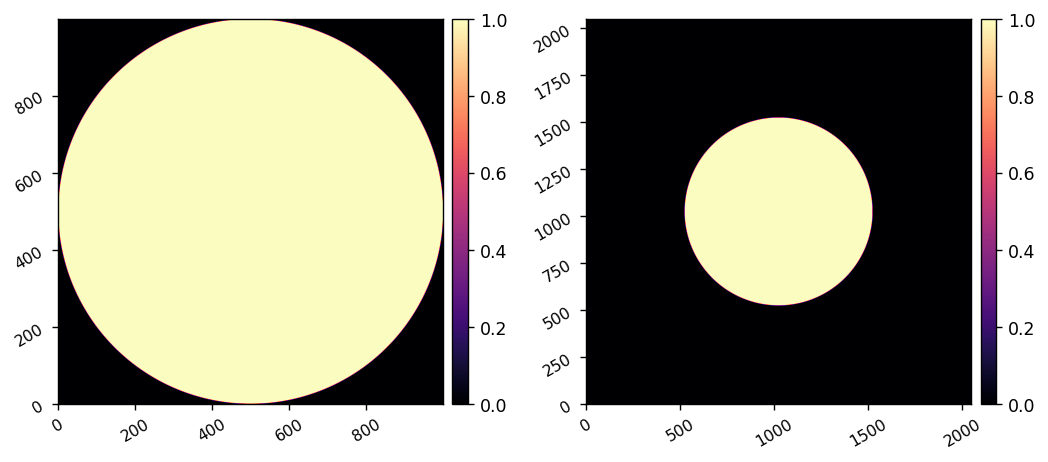

In [2]:
circ = utils.load_fits('../apra_pop_models/pupil_gray_1000.fits')
padded_circ = utils.pad_or_crop(circ, 2048)
print(xp.sum(padded_circ))
imshow2(circ, padded_circ)
np.savetxt('/home/apra/test_ap.csv', padded_circ, delimiter=',')

In [ ]:
np.savetxt('/home/apra/test_mft_ap.csv', mft_circ, delimiter=',')

[-1.024 -1.023 -1.022 ...  1.021  1.022  1.023]
[-25.  -24.8 -24.6 -24.4 -24.2 -24.  -23.8 -23.6 -23.4 -23.2 -23.  -22.8
 -22.6 -22.4 -22.2 -22.  -21.8 -21.6 -21.4 -21.2 -21.  -20.8 -20.6 -20.4
 -20.2 -20.  -19.8 -19.6 -19.4 -19.2 -19.  -18.8 -18.6 -18.4 -18.2 -18.
 -17.8 -17.6 -17.4 -17.2 -17.  -16.8 -16.6 -16.4 -16.2 -16.  -15.8 -15.6
 -15.4 -15.2 -15.  -14.8 -14.6 -14.4 -14.2 -14.  -13.8 -13.6 -13.4 -13.2
 -13.  -12.8 -12.6 -12.4 -12.2 -12.  -11.8 -11.6 -11.4 -11.2 -11.  -10.8
 -10.6 -10.4 -10.2 -10.   -9.8  -9.6  -9.4  -9.2  -9.   -8.8  -8.6  -8.4
  -8.2  -8.   -7.8  -7.6  -7.4  -7.2  -7.   -6.8  -6.6  -6.4  -6.2  -6.
  -5.8  -5.6  -5.4  -5.2  -5.   -4.8  -4.6  -4.4  -4.2  -4.   -3.8  -3.6
  -3.4  -3.2  -3.   -2.8  -2.6  -2.4  -2.2  -2.   -1.8  -1.6  -1.4  -1.2
  -1.   -0.8  -0.6  -0.4  -0.2   0.    0.2   0.4   0.6   0.8   1.    1.2
   1.4   1.6   1.8   2.    2.2   2.4   2.6   2.8   3.    3.2   3.4   3.6
   3.8   4.    4.2   4.4   4.6   4.8   5.    5.2   5.4   5.6   5.8   6.
   6.2

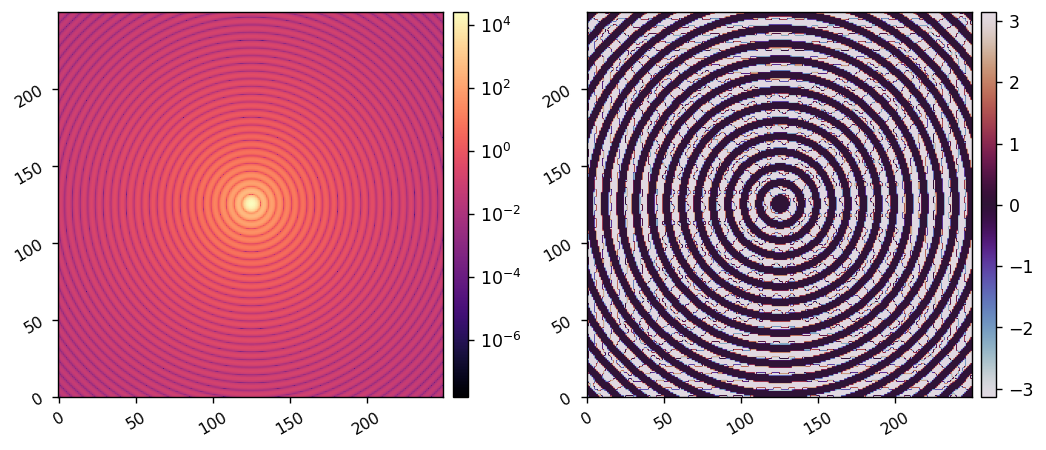

801865.3170778065


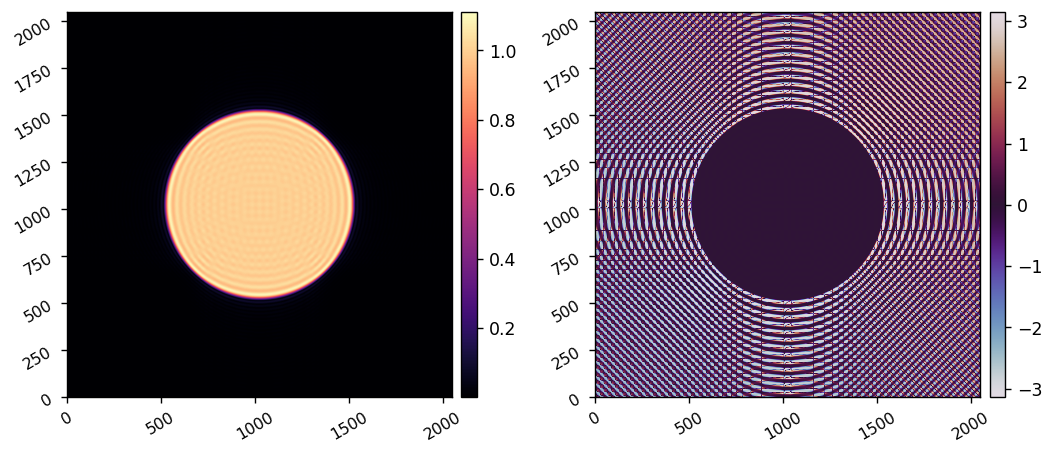

In [12]:
reload(props)
psf_wf = props.mft_forward(padded_circ, 1000, 250, 0.2)
imshow2(xp.abs(psf_wf)**2, xp.angle(psf_wf), lognorm1=1, cmap2='twilight')

mft_circ = props.mft_reverse(psf_wf, 0.2, 1000, 2048)
print(xp.sum(xp.abs(mft_circ)))
imshow2(xp.abs(mft_circ), xp.angle(mft_circ), cmap2='twilight')

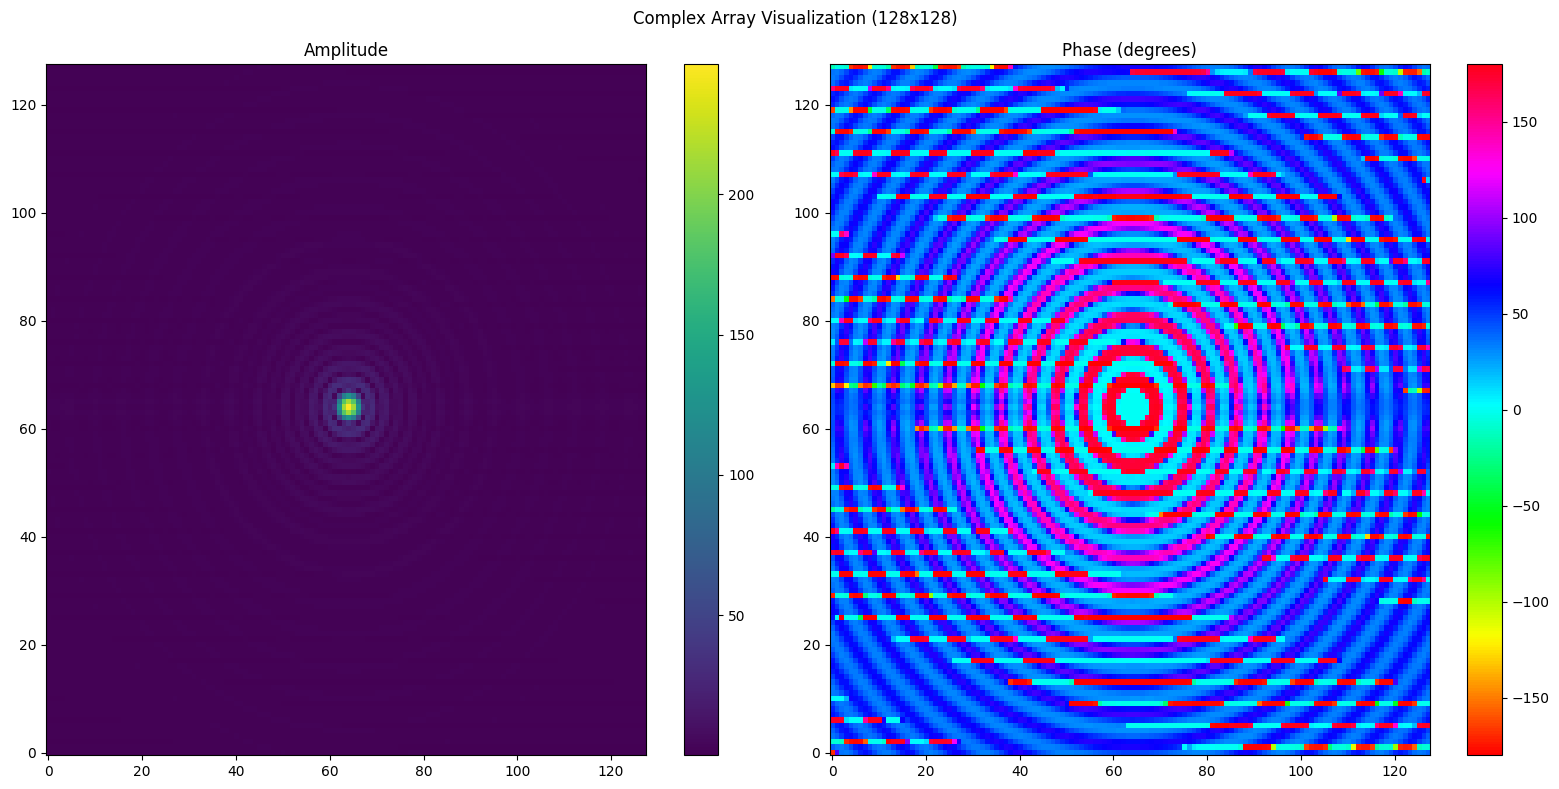

Amplitude statistics:
Min: 0.01
Max: 246.34
Mean: 2.02

Phase statistics:
Min: -179.99°
Max: 179.99°
Mean: 43.73°

Dimensions:
Total entries: 16384
Array shape: 128 rows x 128 columns


In [3]:

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import re

def analyze_new_complex_csv(filename, width):
    """
    Analyze and plot complex data from CSV with 'real' and 'imag' columns.
    Wraps data into a matrix based on specified width.
    
    Args:
        filename (str): Path to the CSV file
        width (int): Number of entries per row
    
    Returns:
        tuple: (complex_array, total_entries, rows, cols)
    """
    # Read the CSV file
    data = pd.read_csv(filename)
    
    # Verify if the CSV has complex data
    if 'real' not in data.columns or 'imag' not in data.columns:
        raise ValueError("CSV must have 'real' and 'imag' columns")
    
    # Get total entries and calculate dimensions
    total_entries = len(data)
    height = math.ceil(total_entries / width)  # Calculate height based on width
    
    # Create complex array
    complex_array = data['real'].values + 1j * data['imag'].values
    
    # Pad the array if necessary to match dimensions
    if total_entries < (width * height):
        pad_size = (width * height) - total_entries
        complex_array = np.pad(complex_array, (0, pad_size), mode='constant', constant_values=0+0j)
    
    # Reshape using the specified width
    complex_array = complex_array.reshape(height, width)
    
    # Calculate amplitude and phase
    amplitude = np.abs(complex_array)
    phase = np.angle(complex_array, deg=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    im1 = ax1.imshow(amplitude, cmap='viridis', aspect='auto')  # Added aspect='auto' for non-square matrices
    ax1.set_title('Amplitude')
    plt.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(phase, cmap='hsv', aspect='auto')  # Added aspect='auto' for non-square matrices
    ax2.set_title('Phase (degrees)')
    plt.colorbar(im2, ax=ax2)
    plt.suptitle(f'Complex Array Visualization ({height}x{width})')
    plt.tight_layout()

    plt.show()
    
    # Print all statistics
    print(f"Amplitude statistics:")
    print(f"Min: {np.min(amplitude):.2f}")
    print(f"Max: {np.max(amplitude):.2f}")
    print(f"Mean: {np.mean(amplitude):.2f}")
    
    print(f"\nPhase statistics:")
    print(f"Min: {np.min(phase):.2f}°")
    print(f"Max: {np.max(phase):.2f}°")
    print(f"Mean: {np.mean(phase):.2f}°")
    
    print(f"\nDimensions:")
    print(f"Total entries: {total_entries}")
    print(f"Array shape: {height} rows x {width} columns")
    
    return complex_array, total_entries, height, width


# Load CSV file
file_path = '/home/apra/Documents/images/end_to_end/psf.csv'
my_width = 128
complex_array, entries, rows, cols = analyze_new_complex_csv(file_path, my_width)

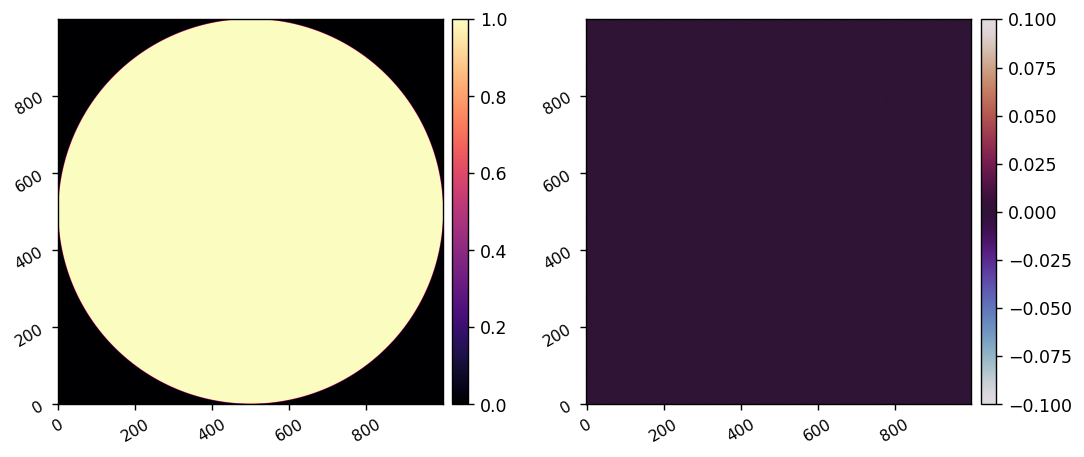

In [2]:
import pandas as pd
import math

def load_model_data(fname, width):
    data = pd.read_csv(fname)

    # Verify if the CSV has complex data
    if 'real' not in data.columns or 'imag' not in data.columns:
        raise ValueError("CSV must have 'real' and 'imag' columns")

    # Get total entries and calculate dimensions
    total_entries = len(data)
    height = math.ceil(total_entries / width)  # Calculate height based on width

    # Create complex array
    complex_array = data['real'].values + 1j * data['imag'].values

    # Pad the array if necessary to match dimensions
    if total_entries < (width * height):
        pad_size = (width * height) - total_entries
        complex_array = np.pad(complex_array, (0, pad_size), mode='constant', constant_values=0+0j)

    # Reshape using the specified width
    complex_array = xp.array( complex_array.reshape(height, width) )

    return complex_array

data = load_model_data('/home/apra/Documents/images/end_to_end/initial_aperture.csv', 1000)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(amplitude, phase, cmap2='twilight')

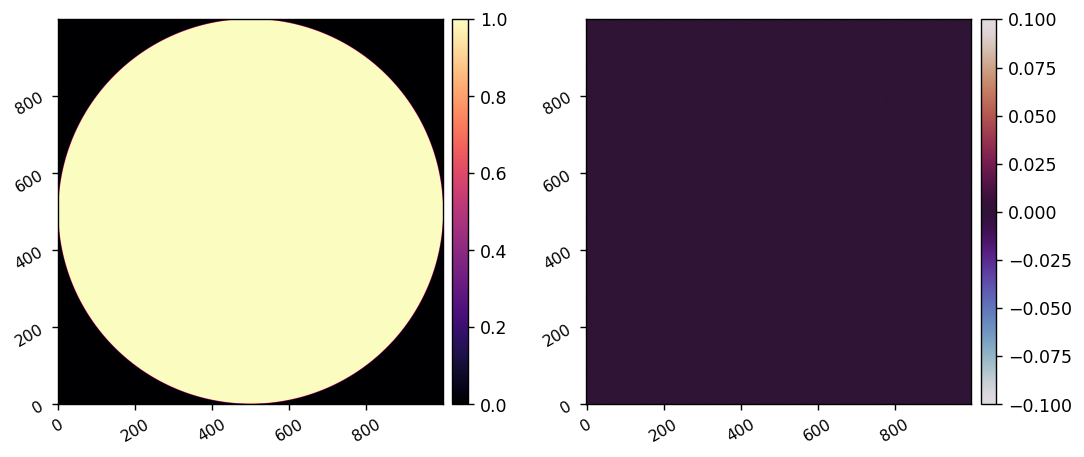

In [18]:
data = load_model_data('/home/apra/Documents/images/end_to_end/post_dm1.csv', 1000)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(amplitude, phase, cmap2='twilight')

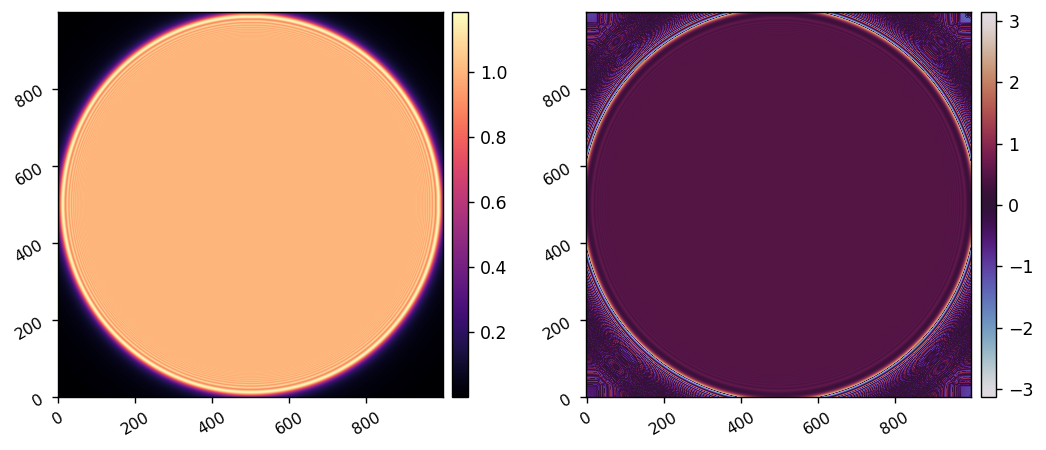

In [19]:
data = load_model_data('/home/apra/Documents/images/end_to_end/E_DM2P.csv', 2048)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(amplitude, phase, cmap2='twilight', npix=1000)

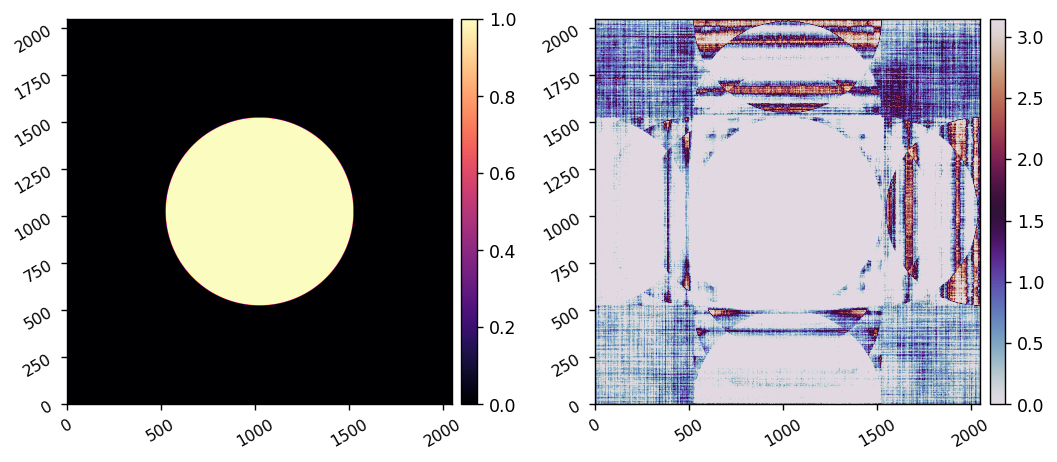

In [3]:
data = load_model_data('/home/apra/Documents/images/end_to_end/pre_FPM.csv', 2048)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

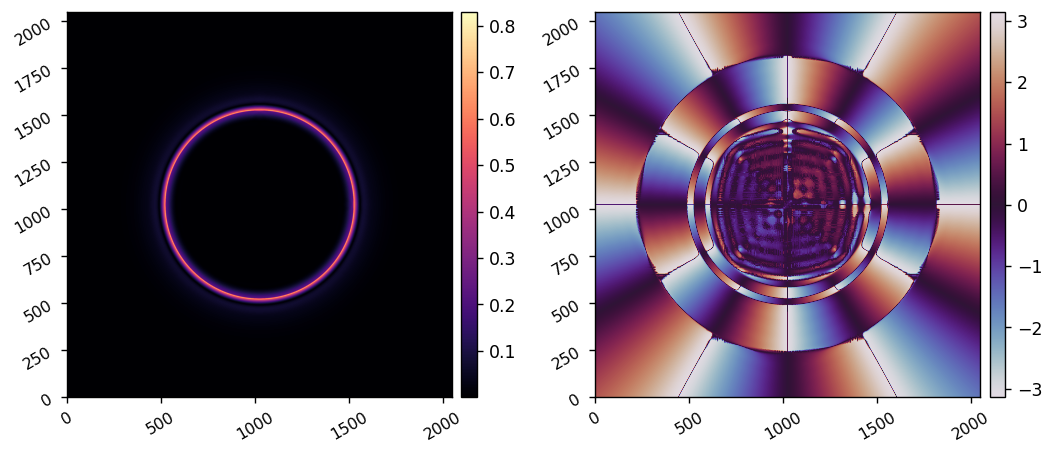

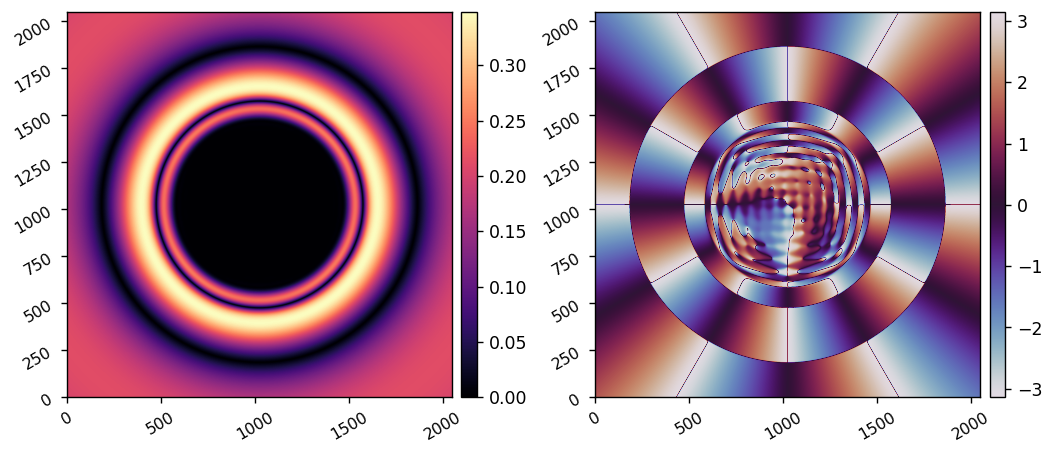

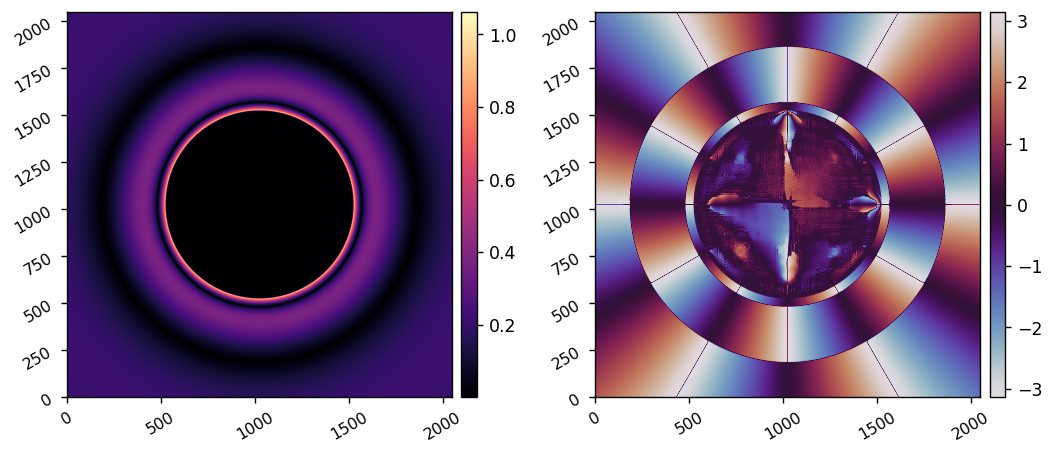

In [21]:
pup_hr = load_model_data('/home/apra/Documents/images/end_to_end/pupil_wavefront_low_res_c_result.csv', 2048)
amplitude = xp.abs(pup_hr)
phase = xp.angle(pup_hr)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

pup_lr = load_model_data('/home/apra/Documents/images/end_to_end/pupil_wf_high_res_c_result.csv', 2048)
amplitude = xp.abs(pup_lr)
phase = xp.angle(pup_lr)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

pup_total = pup_hr + pup_lr
amplitude = xp.abs(pup_total)
phase = xp.angle(pup_total)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)


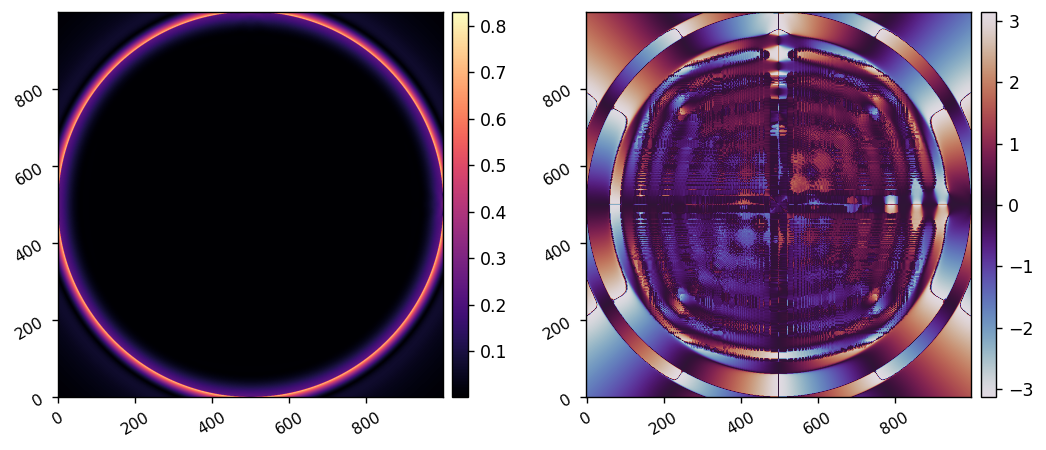

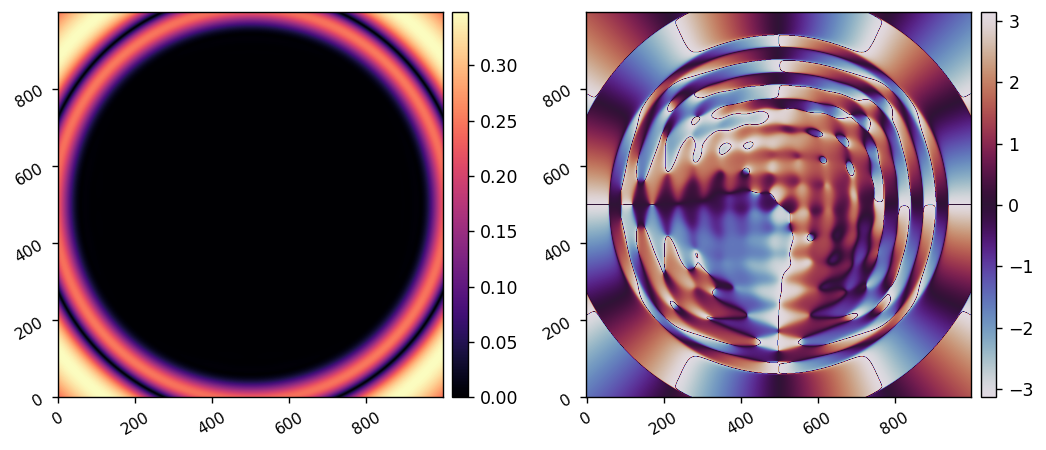

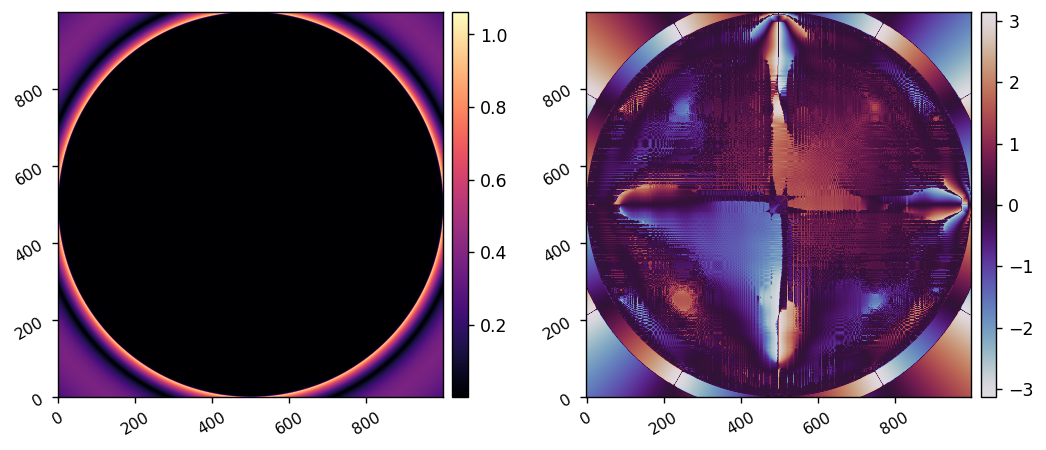

In [28]:
pup_hr = load_model_data('/home/apra/Documents/images/end_to_end/pupil_wf_low_res_c_result.csv', 1000)
amplitude = xp.abs(pup_hr)
phase = xp.angle(pup_hr)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

pup_lr = load_model_data('/home/apra/Documents/images/end_to_end/pupil_wf_high_res_c_result.csv', 1000)
amplitude = xp.abs(pup_lr)
phase = xp.angle(pup_lr)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

pup_total = pup_hr + pup_lr
amplitude = xp.abs(pup_total)
phase = xp.angle(pup_total)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)


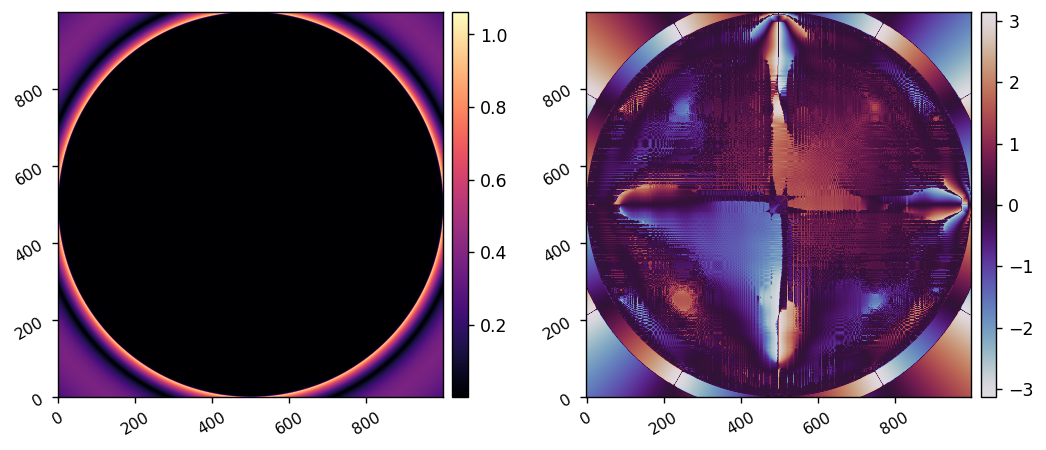

In [30]:
data = load_model_data('/home/apra/Documents/images/end_to_end/post_vortex.csv', 1000)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

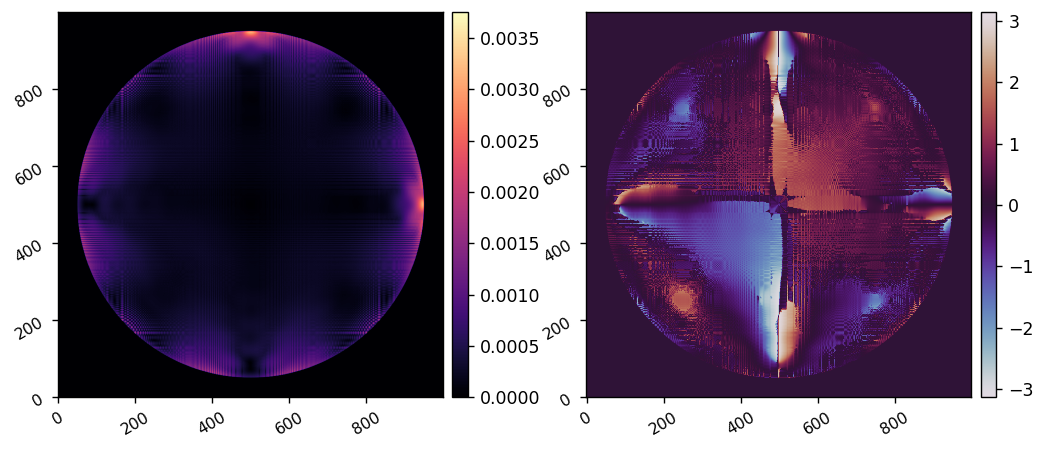

In [31]:
data = load_model_data('/home/apra/Documents/images/end_to_end/after_lyot.csv', 1000)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(
    amplitude, 
    phase, 
    cmap2='twilight', 
    # npix=1000,
)

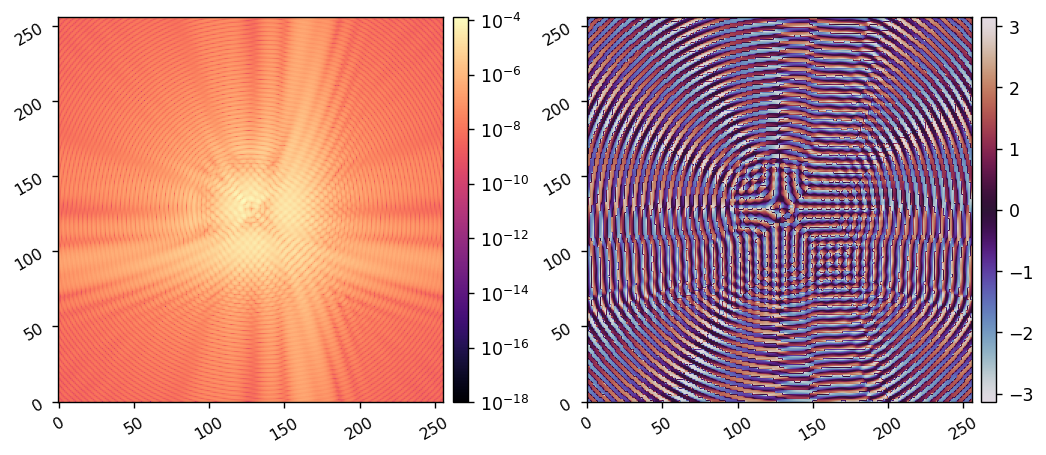

In [34]:
data = load_model_data('/home/apra/Documents/images/end_to_end/psf.csv', 256)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(amplitude**2, phase, lognorm1=True, cmap2='twilight', vmin2=-np.pi)

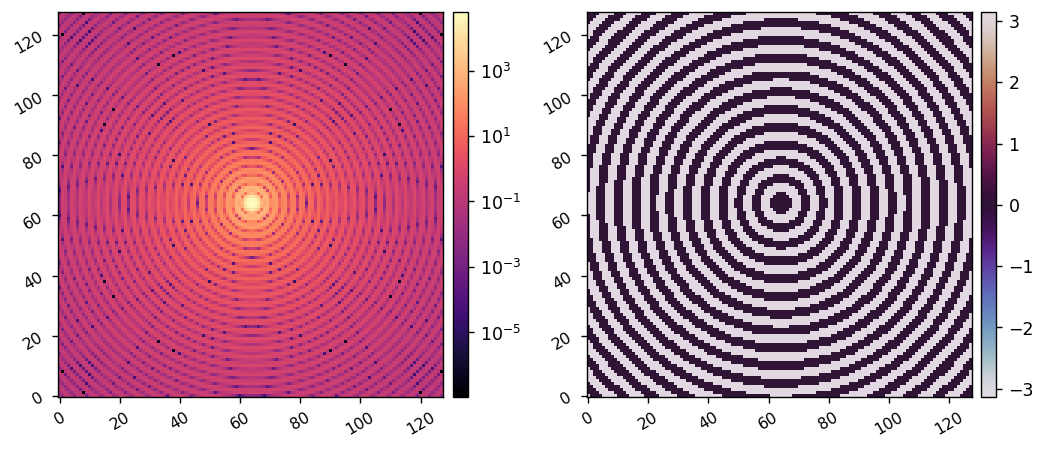

In [17]:
data = load_model_data('/home/apra/Documents/images/end_to_end/psf.csv', 128)

amplitude = xp.abs(data)
phase = xp.angle(data)

imshow2(amplitude**2, phase, lognorm1=True, cmap2='twilight', vmin2=-np.pi)